In [3]:
!pip install datasets

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.10.1
    Uninstalling fsspec-2021.10.1:
      Successfully uninstalled fsspec-2021.10.1


In [2]:
from datasets import load_dataset
import pandas as pd
import transformers
import torch
import warnings
warnings.simplefilter('ignore')
import numpy as np

In [3]:
import torch.nn as nn

In [4]:
import warnings
warnings.simplefilter('ignore')

Возьмем готовый датасет с эмоциями. Это задача классификации текстов на 6 классов: гнев, любовь, страх, радость, печаль и удивление

In [5]:
# Подгружаем датасет
emotions = load_dataset('emotion')

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/Решин Кирилл/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Смотрим как наш датасет вообще устроен

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Датасет уже разделен на три части: трейн, тест и валидация. Количество элементов в каждой выборке: 16000, 2000 и 2000. Смотрим на примеры:

In [7]:
emotions['train']['text'][0:10], emotions['train']['label'][0:10]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy',
  'ive been feeling a little burdened lately wasnt sure why that was',
  'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
  'i feel as confused about life as a teenager or as jaded as a year old man',
  'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
  'i feel romantic too'],
 [0, 0, 3, 2, 3, 0, 5, 4, 1, 2])

In [8]:
emotions['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
emotions.set_format('pandas')
train = emotions['train'][:]
train['label_name'] = \
                    train['label'].apply(lambda x: 
                             emotions['train'].features['label'].int2str(x))
train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [10]:
label_to_class = {}
for i in range(6):
    label_to_class[i] = emotions['train'].features['label'].int2str(i)
label_to_class

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [11]:
import matplotlib.pyplot as plt

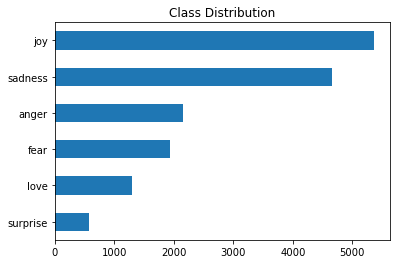

In [12]:
train['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Class Distribution')
plt.show()

Есть некая несбалансированность классов

In [13]:
emotions.reset_format()

Перейдем к обработке текста. Импортим токенайзер и кодируем тексты

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [15]:
code = tokenizer('Here is an example of some random text to tokenize...')
code

{'input_ids': [101, 2182, 2003, 2019, 2742, 1997, 2070, 6721, 3793, 2000, 19204, 4697, 1012, 1012, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
# Смотрим на декодировку всего этого
toks = tokenizer.convert_ids_to_tokens(code.input_ids)
toks

['[CLS]',
 'here',
 'is',
 'an',
 'example',
 'of',
 'some',
 'random',
 'text',
 'to',
 'token',
 '##ize',
 '.',
 '.',
 '.',
 '[SEP]']

In [17]:
print('Vocab size:', tokenizer.vocab_size)
print('Max context size:', tokenizer.model_max_length)

Vocab size: 30522
Max context size: 512


In [18]:
max_len = 0
for i in range(16000):
    max_len = max(len(train.iloc[i].text.split()), max_len)
max_len

66

Итого максимальный размер контекста в нашем датасете не превышает порога в 512 слов, что хорошо. Не надо применять дополнительную обработку. Начнем с токенизации текста

In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
emotions_encoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Скачиваем предобученную модель для fine tunning'a

In [23]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained("distilbert-base-uncased", num_labels=num_labels)
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [24]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [25]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=15,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none"
)

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.751700,0.235705,0.916000,0.915463
2,0.194000,0.170760,0.931500,0.931844
3,0.129100,0.163576,0.931000,0.931444
4,0.102100,0.155475,0.935500,0.935490
5,0.084500,0.161207,0.934000,0.933475
6,0.065600,0.168443,0.937500,0.936774
7,0.055600,0.187203,0.936000,0.936357
8,0.044300,0.202009,0.938000,0.938340
9,0.037200,0.204039,0.937000,0.936680
10,0.029300,0.212165,0.939000,0.939019


TrainOutput(global_step=3750, training_loss=0.10542309684753418, metrics={'train_runtime': 26239.5762, 'train_samples_per_second': 9.146, 'train_steps_per_second': 0.143, 'total_flos': 5402571462720000.0, 'train_loss': 0.10542309684753418, 'epoch': 15.0})

После 4ой эпохт уже видим, что лосс на тесте растет, то есть пошло переобучение

In [27]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.2453051507472992,
 'test_accuracy': 0.9405,
 'test_f1': 0.9405247658219095,
 'test_runtime': 59.8612,
 'test_samples_per_second': 33.411,
 'test_steps_per_second': 0.535}

Accuracy на тесте уже почти 90% после одной эпохи, потом дообучим, сейчас посмотрим на рельтаты и примеры

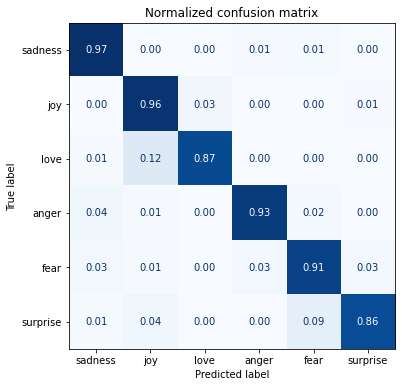

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

labels = emotions["train"].features["label"].names
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, emotions['validation']['label'], labels)

Самый не популярный класс предсказывается хуже всего

Пусть теперь пользователь дает нам какой-то текст. Напишем код, который будет каждый раз выполняться

In [29]:
from datasets import Dataset
import torch.nn.functional as F

In [30]:
text = 'im feeling quite sad and sorry for myself but ill snap out of it soon'

In [31]:
def top_p(
    trainer,
    text,
    top_p: float = 0.95,
) -> list:

    filter_value=-float('Inf')
    answ = []
    
    dct = {}
    dct = tokenizer(text, padding=True, truncation=True)
    dct['text'] = text
    a = []
    a.append(dct)
    logits = F.softmax(torch.tensor(trainer.predict(Dataset.from_list(a)).predictions))
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    
    p = 0
    for i in sorted_indices[0]:
        i = int(i)
        if p > top_p:
            break
        answ.append(label_to_class[i] + ' - ' + str(round(float(logits[0][i]), 2)) + '%')
        p += float(logits[0][i])
    return ', '.join(answ)

In [32]:
top_p(trainer, text)

'sadness - 1.0%'

In [33]:
top_p(trainer, 'some random text with no emotions in it')

'fear - 0.73%, anger - 0.25%'

In [34]:
top_p(trainer, 'i do not think i would like to go out today, i would better stay at home')

'joy - 0.99%'

Тут видимо модель отреагировала на слово like, но не заметила отрицание в начале

In [35]:
top_p(trainer, 'this transformer model is very nice and good')

'joy - 1.0%'

In [38]:
emotions['test'][0]['text'], top_p(trainer, emotions['test'][0]['text']), label_to_class[emotions['test'][0]['label']]

('im feeling rather rotten so im not very ambitious right now',
 'sadness - 1.0%',
 'sadness')

In [48]:
top_p(trainer, 'i am scared and surprised at one time')

'fear - 0.77%, surprise - 0.23%'

In [44]:
top_p(trainer, 'i am not scared')

'fear - 1.0%'

Не смог заменить отрицание, но тут нет альтернативы

In [42]:
top_p(trainer, 'i am not scared, but rather surprised')

'surprise - 0.99%'

При альтернативе он ее определил, что хорошо

In [51]:
top_p(trainer, 'love scare surprise sad happy angry')

'anger - 0.8%, joy - 0.12%, fear - 0.04%'

Модель очень уверенна в своих предсказаниях, что происходит из-за переобучение. Вдобавок мы видим, что фокусировка внимания приходится скорее на последние ключевые слова, видимо, в трейне нету сложных кейсов, где есть отрицания или другие логичекие высказывания. То есть модель хорошо вычленяет какие-то релевантные ключевые слова. Попробуем обучить поменьше эпох, до 4ой, чтобы не было переобучения

In [57]:
num_labels = 6
model1 = (AutoModelForSequenceClassification
        .from_pretrained("distilbert-base-uncased", num_labels=num_labels)
        .to(device))

training_args1 = TrainingArguments(
    output_dir='new_not_overfit_version',
    num_train_epochs=4,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none"
)

trainer1 = Trainer(
    model=model1,
    args=training_args1,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer,
)

trainer1.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.777500,0.278990,0.908500,0.906983
2,0.214100,0.173999,0.927500,0.927641
3,0.140900,0.161573,0.932000,0.932156
4,0.111900,0.155952,0.933500,0.933879


TrainOutput(global_step=1000, training_loss=0.3111059036254883, metrics={'train_runtime': 7016.0602, 'train_samples_per_second': 9.122, 'train_steps_per_second': 0.143, 'total_flos': 1440685723392000.0, 'train_loss': 0.3111059036254883, 'epoch': 4.0})

In [59]:
top_p(trainer1, 'love scare surprise sad happy angry')

'anger - 0.75%, fear - 0.1%, joy - 0.07%, sadness - 0.06%'

In [60]:
top_p(trainer1, 'i am not scared, but rather surprised')

'surprise - 0.92%, fear - 0.07%'

In [61]:
top_p(trainer1, 'i am scared and surprised at one time')

'surprise - 0.72%, fear - 0.26%'

In [62]:
top_p(trainer1, 'i do not think i would like to go out today, i would better stay at home')

'joy - 0.75%, anger - 0.13%, sadness - 0.08%'

О, в этот раз хотя бы в top 95% присутсвует грусть